In [1]:
#import pybedtools

import numpy as np
import pandas as pd

#import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
#import seaborn.objects as so

from scipy.stats import pearsonr, spearmanr
import glob

In [2]:
path = "/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/All_TFBS.csv"
#path = r"C:\Users\julia\MyPython\BA\All_TFBS.csv"
df_combined = pd.read_csv(path)
df_combined = df_combined[df_combined["chr"] != "chrM"]

In [3]:
geneID_filter = df_combined.groupby(["geneID"]).cumcount()

In [4]:
geneID_df = df_combined[geneID_filter == 0]

## Correlation Flat

In [25]:
def flatten_tissues_expand_df(tfbs_df, tissue_iloc =9):
    tfbs_part_repeat = tfbs_df.iloc[:,:tissue_iloc]
    tfbs_part_flatten = tfbs_df.iloc[:,tissue_iloc:]
    
    repeat_df =  pd.DataFrame(np.repeat(tfbs_part_repeat.values, tfbs_part_flatten.shape[1], axis=0))
    flatten_arr = tfbs_part_flatten.to_numpy().flatten()

    tissue_repeat = np.tile(np.array(tfbs_part_flatten.columns), len(tfbs_part_repeat))
    
    repeat_df.columns = tfbs_part_repeat.columns
    repeat_df["GeneExpr"] = flatten_arr
    repeat_df["Tissue"] = tissue_repeat
    
    return repeat_df


def get_pearson(df, x="homotypic_count", tissue="GeneExpr"):
    tfs = df["tf"].unique()
    r_lst = []
    p_lst = []
    tf_lst = []
    for tf in tfs:
        df_tf = df[df["tf"] == tf]
        if len(df_tf) >= 2:
            r, p_value = pearsonr(df_tf[x], np.array(df_tf[tissue]))
            r_lst.append(r)
            p_lst.append(p_value)
            tf_lst.append(tf)
        else:
            print(f"{tf} has less then 2 entrys. No Correlation could be calculated")
    pearson_df = pd.DataFrame({"TFs":tf_lst, "Pearson_r":r_lst, "Pearson_p":p_lst})

    return pearson_df

In [39]:
geneID_df_flat = flatten_tissues_expand_df(geneID_df)
geneID_df_flat_no_zeros = geneID_df_flat[geneID_df_flat["GeneExpr"] !=0]
geneID_df_flat_no_zeros

,chr,geneID,tf,close_tss,dist_tss,strand_orientation,homotypic_count,all_tfbs_count,all_tfbs_unique_count,GeneExpr,Tissue
0,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,0.691,Adipose - Subcutaneous
1,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.043,Adipose - Visceral (Omentum)
2,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.906,Adrenal Gland
3,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.397,Artery - Aorta
4,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.385,Artery - Coronary
...,...,...,...,...,...,...,...,...,...,...,...
934411,chr22,ENSG00000189269.12,STAT5B,55,70,T,1,1,1,125.500,Testis
934412,chr22,ENSG00000189269.12,STAT5B,55,70,T,1,1,1,4.259,Thyroid
934413,chr22,ENSG00000189269.12,STAT5B,55,70,T,1,1,1,2.740,Uterus
934414,chr22,ENSG00000189269.12,STAT5B,55,70,T,1,1,1,1.837,Vagina


In [35]:
# Get Pearson: Number of unique TFBS   vs.    Gene Expression
pearson_geneID = pearsonr(geneID_df_flat_no_zeros["all_tfbs_unique_count"], np.log2(geneID_df_flat_no_zeros["GeneExpr"]))
pearson_geneID

PearsonRResult(statistic=0.3258051054526529, pvalue=0.0)

### Plot Genexpression as scatter

<Axes: xlabel='all_tfbs_unique_count', ylabel='GeneExpr'>

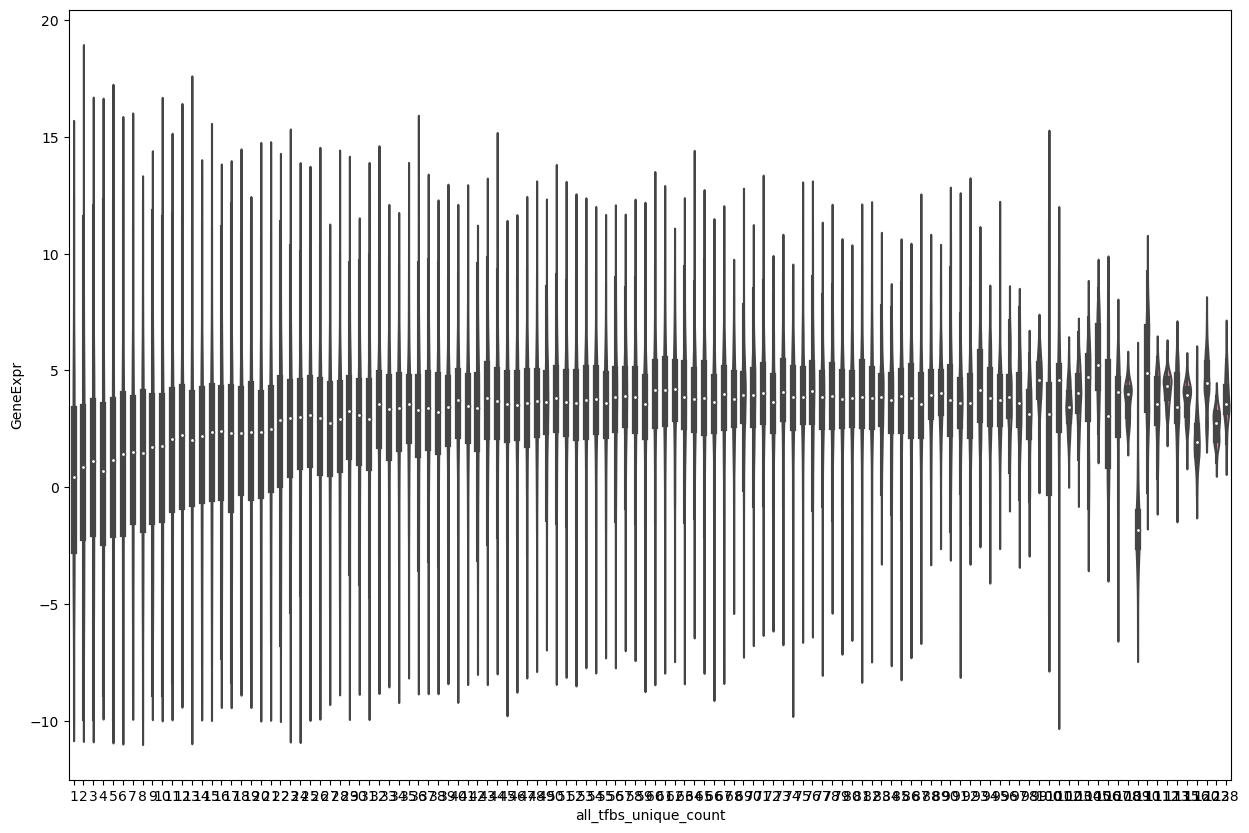

In [70]:
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(geneID_df_flat_no_zeros, x="all_tfbs_unique_count", y=np.log2(geneID_df_flat_no_zeros["GeneExpr"]))

## Correlation for all Tissues

In [130]:
def get_pearson_all_tissues_unique_count(df, x="all_tfbs_unique_count", y_loc_start=9, y_loc_end=None ):
    if y_loc_end is None:
        y_loc_end=len(df.columns)
    tissues = np.array(df.columns[y_loc_start:y_loc_end])
    expr = np.array(df.iloc[:,y_loc_start:y_loc_end])
    
    r_all = np.array([])
    p_all = np.array([])
    for tissue in range(len(tissues)):
        tissue_expr = expr[:,tissue]
        
        r_tissue, p_tissue = pearsonr(df[x], tissue_expr)
        r_all = np.append(r_all, r_tissue)
        p_all = np.append(p_all, p_tissue)
    df = pd.DataFrame({"Pearson_r":r_all, "p_value":p_all})
    df.index = tissues
    return df

In [176]:
def get_pearson_all_tissues_unique_count_log2_expr(df, x="all_tfbs_unique_count", y_loc_start=9, y_loc_end=None ):
    if y_loc_end is None:
        y_loc_end=len(df.columns)
    tissues = np.array(df.columns[y_loc_start:y_loc_end])
    expr = np.array(df.iloc[:,y_loc_start:y_loc_end])
    
    
    r_all = np.array([])
    p_all = np.array([])
    for tissue in range(len(tissues)):
        tissue_expr = expr[:,tissue]
        
        expr_iszero_mask = tissue_expr != 0
        x_reduced = df[x][expr_iszero_mask]
        tissue_expr_reduced = tissue_expr[expr_iszero_mask]
        
        r_tissue, p_tissue = pearsonr(np.log2(x_reduced), np.log2(tissue_expr_reduced))
        r_all = np.append(r_all, r_tissue)
        p_all = np.append(p_all, p_tissue)
    df = pd.DataFrame({"Pearson_r":r_all, "p_value":p_all})
    df.index = tissues
    return df

In [178]:
get_pearson_all_tissues_unique_count_log2_expr(geneID_df)

,Pearson_r,p_value
Adipose - Subcutaneous,0.341509,0.000000e+00
Adipose - Visceral (Omentum),0.337352,0.000000e+00
Adrenal Gland,0.367122,0.000000e+00
Artery - Aorta,0.335180,0.000000e+00
Artery - Coronary,0.341240,0.000000e+00
Artery - Tibial,0.337572,0.000000e+00
Bladder,0.366989,0.000000e+00
Brain - Amygdala,0.302369,0.000000e+00
Brain - Anterior cingulate cortex (BA24),0.299326,0.000000e+00
Brain - Caudate (basal ganglia),0.311082,0.000000e+00


In [110]:
geneID_df

,chr,geneID,tf,close_tss,dist_tss,strand_orientation,homotypic_count,all_tfbs_count,all_tfbs_unique_count,Adipose - Subcutaneous,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,0.691,...,1.121,0.967,1.650,2.041,1.969,2.102,1.274,2.616,4285.500,0.483
1,chr1,ENSG00000143569.18,HMBOX1,9,19,T,1,12,11,50.840,...,49.715,53.410,35.470,39.380,26.340,65.410,60.040,65.595,55.225,17.250
2,chr10,ENSG00000213390.10,HMBOX1,47,57,nT,1,73,55,7.477,...,9.733,9.144,8.263,20.150,4.508,32.780,6.792,10.970,8.785,7.745
3,chr1,ENSG00000169241.17,HMBOX1,160,170,nT,1,115,81,31.560,...,41.695,40.380,46.890,52.560,33.060,22.880,46.590,30.335,32.340,18.380
4,chr1,ENSG00000185499.16,HMBOX1,173,183,nT,1,23,20,5.235,...,6.015,6.711,9.300,3.004,362.500,36.160,28.620,21.455,22.830,0.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694153,chr2,ENSG00000144481.16,KLF9,65,81,T,1,1,1,0.011,...,0.015,0.030,0.014,0.036,0.005,0.718,0.000,0.000,0.027,0.009
694981,chr2,ENSG00000198914.3,KLF9,148,164,T,1,1,1,2.123,...,0.915,2.627,0.194,0.027,0.090,0.567,0.048,0.036,0.031,0.000
697030,chr15,ENSG00000235711.4,BATF,121,132,nT,1,1,1,0.115,...,0.000,0.029,0.000,0.000,0.000,0.119,0.045,0.018,0.023,0.000
698025,chr17,ENSG00000005381.7,PLAG1,121,135,nT,1,1,1,0.323,...,0.080,0.125,0.309,13.190,0.147,1.192,0.492,0.223,0.141,21.280


## Plot correlation

In [5]:
corr_unique_count = pd.read_table("corr_unique_tfbs.txt")

In [6]:
corr_unique_count

,Pearson_r,p_value
Adipose - Subcutaneous,0.341509,0.000000e+00
Adipose - Visceral (Omentum),0.337352,0.000000e+00
Adrenal Gland,0.367122,0.000000e+00
Artery - Aorta,0.335180,0.000000e+00
Artery - Coronary,0.341240,0.000000e+00
...,...,...
Testis,0.353083,0.000000e+00
Thyroid,0.360200,0.000000e+00
Uterus,0.359484,0.000000e+00
Vagina,0.354377,0.000000e+00


In [ ]:
# For flat_df_reduced
fig, ax = plt.subplots(figsize=(10,20))

norm = plt.Normalize(corr_unique_count["p_value"].min(), corr_unique_count["p_value"].max())
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)

sns.barplot(x=corr_unique_count["Pearson_r"], y=corr_unique_count.index, hue=corr_unique_count["p_value"], width=0.5, palette="rocket")


ax.set_ylabel('Tissues')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation of log2(GeneExpr)')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("p-value")

#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_all_great_p.png")